<img src="IACS.png" alt="IACS logo" style="width: 800px;"/>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.pyplot.gray()

%matplotlib inline

import numpy as np

import theano
import theano.tensor as T
rng = np.random.RandomState(42)

import sys
import time

theano.config.floatX = 'float32'

Using gpu device 0: GeForce GTX 765M


<img src="computeFest_logo.jpeg" alt="ComputeFest logo" style="width: 300px;"/>

# ComputeFest 2015 - Deep Learning Workshop Part 1 - Fully Connected Networks

Today we will focus on fully connected networks. We follow the traditional scheme and tackle the traditional task of hand written digit classification. First we use a shallow classifier, simple logistic regression, to get started. Then we add layers to our model to make it more powerful. But, first let's start by loading and looking at the data. 
We will make heavy use of the resources in the Theano deep learning tutorial. We have it integrated into our git repository as a submodule. You can clone the git repository by doing the following steps:

`git clone --recursive https://github.com/vkaynig/ComputeFest2015_DeepLearning.git`

If you already cloned the repository, but the `DeepLearningTutorial` folder is empty, you need to checkout the submodule. Make sure you are in the folder `ComputeFest2015_DeepLearning` and then execute the following command:

`git submodule update --init --recursive`


Now we have to add this directory to the PythonPath. Depending on the location of your git repository you might have to change this path.





In [2]:
sys.path.insert(1,'./DeepLearningTutorials/code')
sys.path

['',
 './DeepLearningTutorials/code',
 'C:\\Python27\\lib\\site-packages\\pyautodiff-0.0.1-py2.7.egg',
 'C:\\Python27\\lib\\site-packages\\autodiff-0.4-py2.7.egg',
 'C:\\Python27\\lib\\site-packages\\meta-_-py2.7.egg',
 'C:\\Python27\\lib\\site-packages\\distribute-0.6.19-py2.7.egg',
 'C:\\Python27\\lib\\site-packages\\pycuda-2012.1-py2.7-win32.egg',
 'C:\\Python27\\lib\\site-packages\\decorator-3.4.0-py2.7.egg',
 'C:\\Python27\\lib\\site-packages\\pytest-2.6.4-py2.7.egg',
 'C:\\Python27\\lib\\site-packages\\pytools-2014.3.5-py2.7.egg',
 'C:\\Python27\\lib\\site-packages\\colorama-0.3.3-py2.7.egg',
 'C:\\Python27\\lib\\site-packages\\py-1.4.26-py2.7.egg',
 'C:\\Python27\\lib\\site-packages\\appdirs-1.4.0-py2.7.egg',
 "C:\\Users\\vkaynig\\Documents\\ComputeFest2015_DeepLearning\\'.'",
 'C:\\Windows\\SYSTEM32\\python27.zip',
 'C:\\Python27\\DLLs',
 'C:\\Python27\\lib',
 'C:\\Python27\\lib\\plat-win',
 'C:\\Python27\\lib\\lib-tk',
 'C:\\Python27',
 'C:\\Python27\\lib\\site-packages',
 'C:

## The Task: Handwritten Digit Recognition 
Classifying handwritten digits is like the 'hello world' for deep learning methods. It is how everyone normally starts to get used to the models and how to best train them. Interstingly though, it is not just for beginners. There are still papers published nowadays that use MNIST to evaluate new methods. There is some debate on whether this is still useful or not, but we won't care about this discussion for now. 

MNIST consists of 70 000 small image patches, each showing a handwritten digit character in white on a black background. There are 10 different classes (the digits from 0-9). Let's load the data and have a look.

In [3]:
from logistic_sgd import load_data
dataset='mnist.pkl.gz'

## If not already cached this function actually downloads the data
datasets = load_data(dataset)

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]


... loading data


## Theano Shared Variables

In [4]:
print train_set_x


<CudaNdarrayType(float32, matrix)>


Now that looks a bit odd, why can't we see the values of our data matrix? The `load_data` function provided by the deep learning tutorial downloads the data and loads it into a shared variable. Shared variables are an important and genious concept in Theano. What it means is that the data can be shared between the CPU and the GPU without you having to write a single line of code! You basically do not have to care at all where your data lives, unless you are running out of memory, which is another story we can talk about later. For now let us only worry about how we can access the actual values of the data matrix:

In [5]:
print train_set_x.get_value()

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [ ]:
print "Size of the training data matrix: ", train_set_x.get_value().shape

The data is stored with one training sample per row. The original image patches are $28 \times 28$ pixels, hence we have $28 \cdot 28 = 784$ feature columns in our data matrix. We can reshape each row of our data matrix back to the original $28 \times 28$ image patch to visualize what the data looks like.

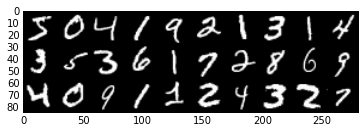

In [7]:
from utils import tile_raster_images

samples = tile_raster_images(train_set_x.get_value(), img_shape=(28,28), 
                             tile_shape=(3,10), tile_spacing=(0, 0),
                             scale_rows_to_unit_interval=True,
                             output_pixel_vals=True)

plt.imshow(samples)
plt.show()

So each image patch contains a hand written digit in white on a black background. The strokes vary in thickness and there is quite some variability in the hand writing. 

The labels of the different image patches are stored in our variable `train_set_y`. When we print this variable it looks different than for our training data, and there is no `get_value()` function that we can call to access the labels.

In [8]:
print train_set_y

Elemwise{Cast{int32}}.0


The reason is that the `load_data` function casted our labels to integers. Why would it do that? The GPU can only store float variables, so all shared variables are stored as float. Our labels are integers though and later on we want to use them as indices, which requires them to be integers. As a workaround `load_data` first stores the labels as floats and then casts them to integer. As you can see from the `print` statement, Theano does not execute the casting right away. Instead it keeps a record of all the computations that are to be performed on the shared variable in a computational graph. This is another genious concept of Theano, because when these graphs get more complicated, it optimizes the whole graph for computational efficiency and numerical stability. If you want to know more about the computational graph structures and their optimization in Theano you can look [here](http://deeplearning.net/software/theano/tutorial/symbolic_graphs.html).

To access the labels we need to tell Theano to exectue all computations from the corresponding graph. We do this by calling `eval()`:

In [9]:
print train_set_y[:10].eval()

[5 0 4 1 9 2 1 3 1 4]


## Exercise: Data Normalization

Deep learning algorithms typically work best when you normalize your data. A standard procedure is to normalize the mean and the standard deviation of each feature column.
Use the training data to estimate the mean normalization, and then use these values to normralize the training, the validation and the test data. Then use the `tile_raster_images` fuction as above to visualize some normalized training patches. Hint: you can basically deal with the shared variables as if they were numpy arrays. 

In [10]:
# estimate the mean and std dev from the training data
# then use these estimates to normalize the data
# estimate the mean and std dev from the training data

norm_mean = train_set_x.mean(axis=0)
train_set_x = train_set_x - norm_mean
norm_std = train_set_x.std(axis=0)
norm_std = norm_std.clip(0.00001, norm_std.max())
train_set_x = train_set_x / norm_std 

test_set_x = test_set_x - norm_mean
test_set_x = test_set_x / norm_std 
valid_set_x = valid_set_x - norm_mean
valid_set_x = valid_set_x / norm_std 

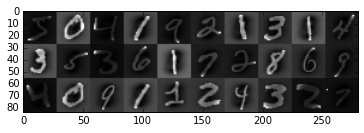

In [11]:
# visualize the result
samples = tile_raster_images(train_set_x.eval(), img_shape=(28,28), 
                             tile_shape=(3,10), tile_spacing=(0, 0),
                             scale_rows_to_unit_interval=True,
                             output_pixel_vals=True)

plt.imshow(samples)
plt.show()

We have to do quite some computations using our training data, so we can just compute the whole graph on the shared variables now and re-assign our shared variables to the new values. 

In [12]:
train_set_x

Elemwise{true_div,no_inplace}.0

In [13]:
train_set_x = theano.shared(train_set_x.eval())
valid_set_x = theano.shared(valid_set_x.eval())
test_set_x = theano.shared(test_set_x.eval())

In [14]:
train_set_x

<CudaNdarrayType(float32, matrix)>

## Logistic Regression

We have seen the basics of logistic regression in the theory part of the workshop. Now it is time to actually apply the method to some data using Theano. We start with this `shallow` classifier and then will add more layers later on. 

From the slides we remember that the logistic regression model has the weight parameters W and the biases b. We need to intialize these as Theano variables. In addition we create placeholders for our data by declaring a data matrix `x`, and a label vector `y`. Note that we do not assign our actual training data to the variables `x` and `y`. Theano can create the whole computational graph for `x` and `y` without knowing the actual values. 

In [15]:
# Step 1. Declare Theano variables
x = T.fmatrix()
y = T.ivector()
# size of our image patches, and number of output units (classes)
W = theano.shared(value=np.zeros((28*28, 10),                            
                dtype=theano.config.floatX),
            name='W',
            borrow=True
        )
b = theano.shared(value=np.zeros((10,), # number of output units (classes)
                dtype=theano.config.floatX),
            name='b',
            borrow=True
        )

Now we create all necessary functions for the computation. We need the likelihood to make predictions, the negative log likelihood as our cost function to optimize, the actual conversion of the class probabilities to class labels, and the classification error. 

In [16]:
# Step 2. Construct Theano expression graph

p_y_given_x = T.nnet.softmax(T.dot(x, W) + b)
y_pred = T.argmax(p_y_given_x, axis=1)

error = T.mean(T.neq(y_pred, y))
#cost = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])
cost = -T.mean(T.log(p_y_given_x)[:, y])

Now comes the really cool part. We do not have to bother to compute the gradient ourselves! Theano is capable of computing the gradient for us. We just call the `T.grad()` function on our cost function and specify with respect to which parameter the derivative should be computed. Then we can use the computed gradient to perform an iteration of gradient decent. We just update the parameters by taking a small step into the right direction on the cost function surface. The size of the step is specified by the learning rate. If you are interested in the best performance for your network, the learning rate is a very important parameter to tune. Typically smaller values work better, but take longer. We will talk more about this in the tips and tricks section of the workshop. 

In [17]:
g_W = T.grad(cost=cost, wrt=W)
g_b = T.grad(cost=cost, wrt=b)

learning_rate = 0.1

updates = [(W, W - learning_rate * g_W),
           (b, b - learning_rate * g_b)]

## Theano Functions

Now we are ready to compile everything we defined so far into a callable function to update our parameters and train our logistic regression classifier. How do we do this? Above we defined our placeholders `x` and `y` for the training data. And we defined `cost` as a function (actually its a Theano computational graph) depending on these placeholders. We now use the `function` interface provided by Theano to create a function that we can call directly on our training data, e.g., binding the training data to the placeholders `x` and `y`. To create this function we need to specify the `inputs` and the `outputs`. In addition the `function` interface has a convenient option to apply our gradient decent updates to the parameters. All we do is pass along the `updates` list we defined in the cell above. 

In [ ]:
# Step 3. Compile expressions to functions
train = theano.function(inputs=[x, y],
                 outputs=cost,
                 updates=updates)

validate = theano.function(inputs=[x, y],
                outputs=error)

As you can see the inputs are our placeholders `x` and `y`. When we call our function `validate` it will ask for two parameters. When we call it with our training samples and their labels, the matrix `train_set_x` gets bound to `x` and `train_set_y` to `y`. The function then traverses the computational graph specified by the outputs, in this case `error`. Thus, the validation function will give us our training error when we call it on the training data. We can also call it on the test data to obtain the test error. 

Now we really have everything in place to train our classifier!

In [ ]:
# Step 4. Perform computation
train_monitor = []
val_monitor = []

n_epochs = 10

start_time = time.clock()
for epoch in range(n_epochs):
    loss = train(train_set_x.eval(), train_set_y.eval())
    train_monitor.append(validate(train_set_x.eval(), train_set_y.eval()))
    val_monitor.append(validate(valid_set_x.eval(), valid_set_y.eval()))
    if epoch%2 == 0:
        print "Iteration: ", epoch
        print "Training error, validation error: ", train_monitor[-1], val_monitor[-1]
end_time = time.clock()    
print 'The code ran for %f seconds' % ((end_time - start_time))

That is ok, but could be faster. All those graph evaluations cost time. Unfortunately Theano functions do not allow shared variables as direct input (more about this soon). So let's at least just do the evaluation once and save it in a normal non-shared variable that we can call our functions with. 

In [ ]:
# Step 4. Perform computation
# reset W and b to zero
W.set_value(np.zeros((28*28, 10),
                dtype=theano.config.floatX)) 
b.set_value(np.zeros((10,),
                dtype=theano.config.floatX))

train_monitor = []
val_monitor = []

n_epochs = 20

trainx = train_set_x.eval()
trainy = train_set_y.eval()
valx = valid_set_x.eval()
valy = valid_set_y.eval()
testx = test_set_x.eval()
testy = test_set_y.eval()

start_time = time.clock()
for epoch in range(n_epochs):
    loss = train(trainx, trainy)
    train_monitor.append(validate(trainx, trainy))
    val_monitor.append(validate(valx,valy))
    if epoch%2 == 0:
        print "Iteration: ", epoch
        print "Training error, validation error: ", train_monitor[-1], val_monitor[-1]
end_time = time.clock()    
print 'The code ran for %f seconds' % ((end_time - start_time))

That looks better. As we already know the number of epochs we are going to train for, we could also fix the size of our monitor variables beforehand and then fill them during training. 

In [ ]:
plt.plot(train_monitor, c='r')
plt.plot(val_monitor, c='b')
plt.xlabel('Number of Epochs')
plt.ylabel('Missclassification')
plt.show()


## Exercise Theano Functions

Write a Theano function that computes the actual predictions for a data set.

In [ ]:
y_hat = theano.function(inputs=[x],
                outputs=y_pred)

y_hat(valx)

## Theano Functions with Shared Variable Input
### Introducing batch training

It seems quite limiting that we are not allowed to just use our shared variables directly as input in the defined Theano functions. After all the whole idea behind the shared variables is to have our data potentially on the GPU, and we don't want to copy it back and forth all the time. There is another mechanism in Theano functions to achieve shared variable input: the `givens` parameter. When I first enocuntered it, I found it very confusing, which is why we are going to look at the conversion of our functions in two steps: First we are going to redefine the training and validation function to work with shared variables, and then we are going to introduce batch training for stochastic gradient decent. For batch training we want to use only part of the data to already compute an update. An epoch then consists of several runs over all batches, until all training data has been seen once, then we start all over again like before. 

First let's look at our definition of the train function and what they look like for shared variables:

In [ ]:
train = theano.function(inputs=[],
                 outputs=[cost, error],
                 updates=updates,
                 givens={x: train_set_x, y: train_set_y}
                 )

validate = theano.function(inputs=[],
                outputs=error,
                givens={x: valid_set_x, y: valid_set_y}
                )

Remember that we defined our `cost` and `error` dependent on the placeholder variables `x` and `y`. Now we are using thing `givens` parameter to substitute `x` and `y` with our training and validation data. This is all the `givens` parameter does. It can be used to replace any symbolic variable, not just shared ones. You can even replace constants or whole expressions. Careful though: Expressions should not be co-dependent, as the order of execution is not defined, so the replacements have to work in any order. 
There is a small price attached to this way of defining our functions. The data is now hardcoded into the definition. This means we either have to define a training_error function, or we can add the error to the output of our training function. 

In [ ]:
# Step 4. Perform computation
# reset W and b to zero
W.set_value(np.zeros((28*28, 10),
                dtype=theano.config.floatX)) 
b.set_value(np.zeros((10,),
                dtype=theano.config.floatX))

train_monitor = []
val_monitor = []

n_epochs = 50

start_time = time.clock()
for epoch in range(n_epochs):
    val_monitor.append(validate())
    loss, err = train()
    train_monitor.append(err)
    if epoch%10 == 0:
        print "Iteration: ", epoch
        print "Training error, validation error: ", train_monitor[-1], val_monitor[-1]
end_time = time.clock()    
print 'The code ran for %f seconds' % ((end_time - start_time))

And we got even faster, nice! Something weird is going on though. Note that the training error of the first iteration is really high and different from what we have seen before. The reason is that the error is computed by the training function before the actual update. To get a fair comparison of train and validation error, we can just call the `validate` function before we do the training step. This means we are missing the final performance of our classifier, so you would have to run an additional evaluation round in the end. Preferably with entirely new test data that you haven't looked at before. 

Let's go further and introduce batch training. The idea is to not estimate the gradient each time over the whole dataset. The gradient estimation typically is already stable after averaging over a few training samples, so using the whole dataset is a waste of time, and it can actually help to have noisy gradient estimations. The reason is that noisy estimations add an exploration factor to our optimization scheme. We basically jump around more, but might find a good local minimum of our energy function on one of our detours. 

To define a training function using batches, we introduce a variable for the batch size and resulting number of batches. Both variables are fixed and defined outside of our function. We also introduce a new input argument `index`. The `index` refers to the index of the specific batch of training data for the next iteration. Note that we now do several updates per epoch. If we have 100 training batches, one epoch now corresponds to 100 updates, instead of one update as before. 

In [ ]:
batch_size = 20
n_train_batches = train_set_x.shape[0].eval() / batch_size
index = T.iscalar() 

train_batch = theano.function(inputs=[index],
                       outputs=cost, 
                       updates=updates,
                       givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

For simplicity I just omitted the classification error from the output. The error provided by one call of this function is just the average missclassification rate for this particular batch. If you want you can add the error output in again and then during training compute the average training error over a whole epoch. 

In [ ]:
# Step 4. Perform computation
# reset W and b to zero
W.set_value(np.zeros((28*28, 10),
                dtype=theano.config.floatX)) 
b.set_value(np.zeros((10,),
                dtype=theano.config.floatX))

val_monitor_batch = []
n_epochs = 10

start_time = time.clock()
for epoch in range(n_epochs):
    for batch_index in range(n_train_batches):
        loss = train_batch(batch_index)        
    val_monitor_batch.append(validate())
    if epoch%1 == 0:
        print "Iteration: ", epoch
        print "Validation error: ",val_monitor_batch[-1]
end_time = time.clock()    
print 'The code ran for %f seconds' % ((end_time - start_time))    

In [ ]:
plt.plot(val_monitor_batch, c='b')
plt.xlabel('Number of Epochs')
plt.ylabel('Missclassification')
plt.show()


Overall our logistic regression seems to be able to reach a missclassification rate of around 7.5%. That is in the range of the result of the (deep learning tutorial)[http://deeplearning.net/tutorial/logreg.html]. But, we have barely started yet! After all this workshop is about deep learning, so let's add some layers to our model! But first it is time for another exercise.

## Exercise: Learning Rate Decay
There are a lot of tips and tricks to influence the training of a neural network. One option is to have the learning rate slowly decay over the iterations. Modify our training function such that the learning rate is multiplied with a factor of $0.995$ after each gradient step. Hint: the idea is to define an update for the learning rate.

In [ ]:
## What we had so far
learning_rate = 0.1

updates = [(W, W - learning_rate * g_W),
           (b, b - learning_rate * g_b)]

train_batch_lr = theano.function(inputs=[index],
                       outputs=cost, 
                       updates=updates,
                       givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

In [ ]:
# your solution
learning_rate = np.array(0.1, dtype=theano.config.floatX)
shared_learning_rate = theano.shared(value=learning_rate, name='lr')

updates = [(W, W - shared_learning_rate * g_W),
           (b, b - shared_learning_rate * g_b),
           (shared_learning_rate, shared_learning_rate * 0.995)]

train_batch_lr = theano.function(inputs=[index],
                       outputs=cost, 
                       updates=updates,
                       givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

In [ ]:
# test your solution by calling the training 
#function and printing the learning rate

for i in xrange(10):
    print shared_learning_rate.get_value()
    train_batch_lr(1)


## Making the model deep

Now that we understand the code for logistic regression, we are going to just use the pre-defined class `LogisticRegression` from the [Theano deep learning tutorial](http://deeplearning.net/tutorial/logreg.html) as our last classification layer. To make our model deeper we need to define a hidden layer. Now that we know about _shared_variables_, _Theano_functions_, and how to do _stochastic_gradient_decent_, this is actually pretty easy, and we can just read and understand the definition of the `HiddenLayer` class from the [Theano deep learning tutorial](http://deeplearning.net/tutorial/mlp.html).

Short recap: 

![MLP](http://deeplearning.net/tutorial/_images/mlp.png)

The hidden layer computes the function $s(b+Wx)$, where $s$ is our activation function, $b$ are the biases and $W$ is the weight matrix. 

In [ ]:
from logistic_sgd import LogisticRegression

class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):

        self.input = input

        if W is None:
            W_values = np.asarray(
                rng.uniform(
                    low=-np.sqrt(6. / (n_in + n_out)),
                    high=np.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]



With the definition of this class we also start to being introduced to the `black magic` of deep networks. The intialization for $W$ looks quite strange. The reason is a paper from [Glorot et al.](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf) which looked at gradient propagation in deep networks and the effect of initialization, and proposed this normalized intialization as a good way to intialize networks with tanh activation. 

So we have now a class for the logistic regression layer and a class for a hidden layer. All that is missing is putting it all together. The class name `MLP` stands for Multi Layer Perceptron.

In [ ]:
class MLP(object):

    def __init__(self, rng, input, n_in, n_hidden, n_out):

        self.hiddenLayer = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_hidden,
            activation=T.tanh
        )

        self.logRegressionLayer = LogisticRegression(
            input=self.hiddenLayer.output,
            n_in=n_hidden,
            n_out=n_out
        )

        self.negative_log_likelihood = (
            self.logRegressionLayer.negative_log_likelihood
        )

        self.errors = self.logRegressionLayer.errors

        self.params = self.hiddenLayer.params + self.logRegressionLayer.params

Note that the input for the logistic regression layer is the output of the hidden layer. This way the two layers are connected in the model. This means we can just use the error and loss functions from the logistic regression layer as the error and loss function of our whole model. This might seem strange at first, but the error of the logistic regression layer is defined in terms of the layer's input. This input now is connected to the output of the hidden layer, thus computing the gradient of the loss function will unravel the whole network all the way down to the first layer's input, which is our image data. 


Now we need to define a new training function along with new functions for testing and validation. We use two separate data sets for validation and testing. The reason is that deep network classifiers have a lot of parameters to tune. We use the training data for the actual gradient decent optimization, but we also have to tune the hyper-parameter, like how many layers to choose, how many units in each layer, which learning rate, activation funtion, etc. In a way this is like a whole second level of optimizing our network. This means our validation data can be seen as part of the training data, just for training different parameters than the training data. The test data then is there to test the generalization performance our our trained network. If you are strict about it, you are only allowed to compute the test error once all parameters in the network are fixed. 

In [ ]:
n_hidden = 100
classifier = MLP(
        rng=rng,
        input=x,
        n_in=28 * 28,
        n_hidden=n_hidden,
        n_out=10
    )

cost = classifier.negative_log_likelihood(y)

n_validation_batches= valid_set_x.shape[0].eval() / batch_size

validate_model = theano.function(
    inputs=[index],
    outputs=classifier.errors(y),
    givens={
            x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            y: valid_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

test_model = theano.function(
    inputs=[],
    outputs=classifier.errors(y),
    givens={
            x: test_set_x,
            y: test_set_y
        }
    )


gparams = [T.grad(cost, param) for param in classifier.params]

learning_rate = 0.1
updates = [(param, param - learning_rate * gparam)
        for param, gparam in zip(classifier.params, gparams)
    ]

train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
 

**Let's give it a try!**

In [ ]:
start_time = time.clock()

n_epochs = 10
start_time = time.clock()

for epoch in xrange(n_epochs):
    for minibatch_index in xrange(n_train_batches):
        minibatch_avg_cost = train_model(minibatch_index)
    
    validation_losses = [validate_model(i) for i
                                     in xrange(n_validation_batches)]
    
    this_validation_loss = np.mean(validation_losses)
    print('epoch %i, minibatches %i, validation error %f %%' %
                    (
                        epoch,
                        n_train_batches,
                        this_validation_loss * 100.
                    )
                )

end_time = time.clock()   
print 'The code ran for %f seconds' % ((end_time - start_time))    

print "Test error is %f %%" % (test_model() * 100)

## Visualizing the Weights

It is very hard to understand what a DNN is actually learning. One way to get a bit of insight is to look at the weight matrix $W$ of the first layer. The weights conveniently have the same size as our input and can be understood as the filters that the DNN learned at the first stage. 

We can again use the `tile_raster_images` function to visualize the weights.

In [ ]:
filters = tile_raster_images(classifier.hiddenLayer.W.T.eval(), img_shape=(28,28), tile_shape=(10,10), tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True)

plt.imshow(filters)
plt.show()

Even though our network was not very optimized, we can see that the filters are starting to form patterns. Some of these patterns can be interpreted as looking for line strokes, which makes sense given that our training data consists of handwritten digits. 

## Exercise: Hidden Unit Activations
It can be useful to not only look at the learned filters, but also at the activation of the hidden units. Write a function that computes the activation of the hidden units for the validation data. The result should be a nr_of_samples $\times$ nr_of_hidden_units matrix. You can visualize the result for the first 100 validation samples. If all is working well the visualization should show a random pattern without obvious horizontal or vertical lines.


In [ ]:
hidden_activation = classifier.hiddenLayer.output
compute_activations = theano.function(inputs=[],
                                      outputs=hidden_activation,
                                      givens={x: valid_set_x})

activation_matrix = compute_activations()
plt.imshow(activation_matrix[:100,:])
plt.xlabel("hidden unit")
plt.ylabel("samples")
plt.show()

## Adding even more Layers
According to the universal approximation theorem a single hidden layer neural network with a linear output unit can approximate any continuous function arbitrarily well, given enough hidden units. The result applies for sigmoid, tanh and many other hidden layer activation functions. While this is a great result and sounds like we don't really need to bother about adding more layers, it can be very hard in practice to find the right local minimum of such a network. It also doesn't specify how many hidden units are enough. It is computationally more feasible to stack moderate size hidden layers on top of each other, than to try and optimize a gigantic single hidden layer. So finally here is the generalization of our `MLP` class for an arbitrary number of hidden layers:



In [ ]:
class MLP_deep(object):
    def __init__(self, rng, input, n_in, n_hidden, n_out):
        
        self.hiddenLayers = []
        
        self.params = []
        
        next_input = input
        next_n_in = n_in
        
        for n_h in n_hidden:
            hl = HiddenLayer(
            rng=rng,
            input=next_input,
            n_in=next_n_in,
            n_out=n_h,
            activation=T.tanh
            )
            next_input = hl.output
            next_n_in = n_h
            self.hiddenLayers.append(hl)
            self.params += hl.params                         


        self.logRegressionLayer = LogisticRegression(
            input=self.hiddenLayers[-1].output,
            n_in=n_hidden[-1],
            n_out=n_out
        )

        self.negative_log_likelihood = self.logRegressionLayer.negative_log_likelihood
        self.errors = self.logRegressionLayer.errors

        self.params += self.logRegressionLayer.params

Note that again we need to take care to get the layers connected by specifying the output of the lower layer as input for the new layer on top. All the rest should look fairly familiar by now:

In [ ]:
n_hidden = [200,100]
classifier = MLP_deep(
        rng=rng,
        input=x,
        n_in=28 * 28,
        n_hidden=n_hidden,
        n_out=10
    )

cost = classifier.negative_log_likelihood(y)

n_validation_batches= valid_set_x.shape[0].eval() / batch_size

validate_model = theano.function(
    inputs=[index],
    outputs=classifier.errors(y),
    givens={
            x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            y: valid_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

test_model = theano.function(
    inputs=[],
    outputs=classifier.errors(y),
    givens={
            x: test_set_x,
            y: test_set_y
        }
    )


gparams = [T.grad(cost, param) for param in classifier.params]

learning_rate = 0.1
updates = [(param, param - learning_rate * gparam)
        for param, gparam in zip(classifier.params, gparams)
    ]

train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
 

**And here we go!**

In [ ]:
start_time = time.clock()

n_epochs = 10
start_time = time.clock()

for epoch in xrange(n_epochs):
    for minibatch_index in xrange(n_train_batches):
        minibatch_avg_cost = train_model(minibatch_index)
    
    validation_losses = [validate_model(i) for i
                                     in xrange(n_validation_batches)]
    this_validation_loss = np.mean(validation_losses)
    print('epoch %i, minibatches %i, validation error %f %%' %
                    (
                        epoch,
                        n_train_batches,
                        this_validation_loss * 100.
                    )
                )

end_time = time.clock()   
print 'The code ran for %f seconds' % ((end_time - start_time))    

print "Test error is %f %%" % (test_model() * 100)

In [ ]:
filters = tile_raster_images(classifier.hiddenLayers[0].W.T.eval(), img_shape=(28,28), tile_shape=(10,10), tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True)

plt.imshow(filters)
plt.show()

## Exercise: Playing around

Possible things to try:

- Play around with the batch size
- Play with different learning rates
- Switch activation function from tanh to sigmoid
- Train a lot of narrow layers
- Train just one very large layer
- add L1 or L2 regularization to the loss function and see the effect (this is also covered in the Theano Deep learning tutorial on MLP)
